In [1]:
#%*This program simulates datasets following DGP1,2,3 in ACF (2015)*/
# and estimates parameters by ACF and KLS approach.
# The original ACF code is written by GAUSS
# KLS rewrite ACF original code into Stata and Matlab
# Here, KLS code and ACF is rewritten into Julia by Suguru Otani

using Distributions
# auxiliary function from Matlab
"""
    linspace(lo::Any,hi::Any,n::Any)
Matlab-like function generates
Inputs:
  - `lo` lowerbound
  - `hi` upperbound
  - `n` number of grids
Output:
  - a sequence equally discretized
"""
function linspace(lo::Any,hi::Any,n::Any)
    x = zeros(n)
    x[1] = lo
    for i in 2:n
        x[i] = x[i-1] +(hi -x[i-1])/(n-i+1)
    end
    return x
end

mutable struct acf_struct
    siglnw::Float64 #%* Measures SD of firm specific wages - For the original DGP1, this should be set to 0.1. We also modify the DGP1 by increasing the standard deviation of the log wage to 0.5 */
    timeb::Float64 #%/* Determines Point in time when labor is chosen*/
    sigoptl::Float64 #%/* Optimization error in labor. For DGP1, this should be set to zero */
    n::Int64   #%/* Number of firms */
    #%/* We decided to take data from an approximate steady state of the dynamic model.  We start firms with (close to) zero level of capital, and run the model for 100 periods (which seemed to get us pretty close to the steady state).
    #The data used in estimation is the last 10 of these periods */
    overallt::Int64  #%/* Number of time periods in simulation in total (~100 seemed to get to approximate steady state) */
    starttime::Int64   #%/* Time period at which observed data starts */
    t::Int64         #%/* Time periods in observed data */
    #%/* Generate epsilons */
    sigeps::Float64
    epsdata::Array{Float64,2} #%epsdata = sigeps*rndn(n,overallt);
    #%/* Generate omega and ln(wage) processes */
    sigomg::Float64  #%/* SD of omega */
    rho::Float64 #%/* AR(1) coefficient for omega */
    rholnw::Float64 #%/* AR(1) coefficient for ln(wage) - note: SD defined at top of program */
    disc::Float64  #%/* Discount rate for dynamic programming problem */
    delta::Float64  #%/* Depreciation rate for capital */
    sigb::Float64 #%/* measures variation in capital adjustment cost across firms */
	rhofirst::Float64
	rhosecond::Float64
	sigxi::Float64
	sigxifirst::Float64
	sigxisecond::Float64
	sigxilnw::Float64  #%/* SD of innovation in ln(wage) - set such that variance of ln(wage) is constant across time */
	alpha0::Float64 #%log(alpha0) = log(1) = 0
	alphal::Float64
	alphak::Float64
end

function acf_mod(;siglnw = 0.1, #%* Measures SD of firm specific wages - For the original DGP1, this should be set to 0.1. We also modify the DGP1 by increasing the standard deviation of the log wage to 0.5 */
	timeb = 0.5, #%/* Determines Point in time when labor is chosen*/
	sigoptl = 0.0, #%/* Optimization error in labor. For DGP1, this should be set to zero */
	n = 1000,   #%/* Number of firms */
	#%/* We decided to take data from an approximate steady state of the dynamic model.  We start firms with (close to) zero level of capital, and run the model for 100 periods (which seemed to get us pretty close to the steady state).
	#The data used in estimation is the last 10 of these periods */
	overallt = 100,  #%/* Number of time periods in simulation in total (~100 seemed to get to approximate steady state) */
	starttime =90,   #%/* Time period at which observed data starts */
	t = 10,          #%/* Time periods in observed data */
	#%/* Generate epsilons */
	sigeps = 0.1,
	epsdata = sigeps.*randn(n,overallt), #%epsdata = sigeps*rndn(n,overallt);
	#%/* Generate omega and ln(wage) processes */
	sigomg = 0.3,  #%/* SD of omega */
	rho = 0.7, #%/* AR(1) coefficient for omega */
	rholnw = 0.3,#%/* AR(1) coefficient for ln(wage) - note: SD defined at top of program */
	disc = 0.95,  #%/* Discount rate for dynamic programming problem */
	delta = 0.2,  #%/* Depreciation rate for capital */
	sigb = 0.6, #%/* measures variation in capital adjustment cost across firms */
	#%/* The next five lines define parameters necessary to subdivide the omega process into omega(t-1) -> omega(t-b) -> omega(t).
	#Note that this depends on the timeb (b) parameter, defined at top of program */
	rhofirst = rho^(1-timeb),
	rhosecond = rho^timeb,
	sigxi = sqrt((1-rho^2)*sigomg^2),  #%/* SD of innovation in omega - set such that variance of omega(t) is constant across time */
	sigxifirst = sqrt((1-rhofirst^2)*sigomg^2),
	sigxisecond = sqrt((1-rhosecond^2)*sigomg^2),
	sigxilnw = sqrt((1-rholnw^2)*siglnw^2),  #%/* SD of innovation in ln(wage) - set such that variance of ln(wage) is constant across time */
	# True parameters
	alpha0 = 1, #%log(alpha0) = log(1) = 0 modified from KLS stata
	alphal = 0.6,
	alphak = 0.4
	)
	# all parameters are flexibly defined
    return  par = acf_struct(siglnw,timeb,sigoptl,n,overallt,starttime,t,
	                         sigeps,epsdata,sigomg,rho,rholnw,disc,delta,
							 sigb,rhofirst,rhosecond,sigxi,sigxifirst,sigxisecond,sigxilnw,alpha0,alphal,alphak)
end
#par = acf_mod()
#%/* Production Function Parameters */
println("Caution: ACF and KLS use confusing notation alpha0=0 since they fix alpha0=1
and log(alpha0)=0. I modified this specification of the constant parameter flexible")

function gen_omega(par::acf_struct)
	n = par.n
	overallt = par.overallt
	alpha0 = par.alpha0
	alphal = par.alphal
	alphak = par.alphak
	sigomg = par.sigomg
	timeb = par.timeb
	rhofirst = par.rhofirst
	rhosecond = par.rhosecond
	sigxifirst = par.sigxifirst
	sigxisecond = par.sigxisecond
	#%/* Period 0 values of omega and ln(wage) */
	omgdata0 = sigomg.*randn(n,1);
	#%/* Period 1-b value of omega
	# and Period 1 values of omega and ln(wage) */
	omgdataminusb[:,1] = rhofirst*omgdata0 + sigxifirst.*randn(n,1);
	omgdata[:,1] = rhosecond*omgdataminusb[:,1] + sigxisecond.*randn(n,1);
	i = 1;
	s = 1;
	while i<=n
		s = 2;
	 while s<=overallt
	        omgdataminusb[i,s] = rhofirst*omgdata[i,s-1] .+ sigxifirst*randn(1,1)[1];
			omgdata[i,s] = rhosecond*omgdataminusb[i,s] + sigxisecond*randn(1,1)[1];
		s=s+1;
	 end
		i=i+1;
	end
	return omgdataminusb,omgdata
end
#omgdataminusb,omgdata = gen_omega(par)

function gen_lnw(par::acf_struct)
	n = par.n
	overallt = par.overallt
	alpha0 = par.alpha0
	alphal = par.alphal
	alphak = par.alphak
	sigomg = par.sigomg
	timeb = par.timeb
	siglnw = par.siglnw
	rholnw = par.rholnw
	sigxilnw = par.sigxilnw
	#%/* Period 0 values of omega and ln(wage) */
	lnwdata0 = siglnw.*randn(n,1);
	#%/* Period 1-b value of omega
	# and Period 1 values of omega and ln(wage) */
	lnwdata[:,1] = rholnw*lnwdata0 + sigxilnw.*randn(n,1);
	#%/* Simulate values of omega and ln(wage) for rest of time periods */
	i = 1;
	s = 1;
	while i<=n
		s = 2;
	 while s<=overallt
			lnwdata[i,s] = rholnw*lnwdata[i,s-1] + sigxilnw*randn(1,1)[1];
		s=s+1;
	 end
		i=i+1;
	end
	return lnwdata
end
#lnwdata = gen_lnw(par)


function gen_investment(par::acf_struct)
	n = par.n
	overallt = par.overallt
	alpha0 = par.alpha0
	alphal = par.alphal
	alphak = par.alphak
	disc = par.disc #%/* Discount rate for dynamic programming problem */
	delta = par.delta #%/* Depreciation rate for capital */
	sigb = par.sigb #%/* measures variation in capital adjustment cost across firms */
	sigoptl = par.sigoptl
	rholnw = par.rholnw
	sigxilnw = par.sigxilnw
	sigxi = par.sigxi
	rho = par.rho
	rhosecond = par.rhosecond
	sigxifirst = par.sigxifirst
	sigxisecond = par.sigxisecond
	lnkdata[:,1] = -100*ones(n,1);  #%/* Initial ln(capital) level (very close to 0 capital) */
	oneoverbiadj = exp.(sigb.*randn(n,1)); #%/* 1/capital adjustment cost (1/phi(i) in appendix) for each firm */

	#%/* Various components of long expression for optimal investment choice (end of ACF(2015) Appendix Section 7.3) */
	squarebracketterm = (alphal^(alphal/(1-alphal)))*exp(0.5*alphal^2*sigoptl^2) - (alphal^(1/(1-alphal)))*exp(0.5*sigoptl^2);
	const1 = disc * (alphak/(1-alphal)) * (exp(log(alpha0))^(1/(1-alphal))) * squarebracketterm;
	vec1 = (disc*(1-delta)).^[0:1:99;];
	vec2 = cumsum(rholnw.^(2*[0:1:99;]));
	vec3 = sigxi^2 * [zeros(1);cumsum(rho.^(2*[0:1:98;]))];
	expterm3 = exp.( 0.5 * ((-alphal)/(1-alphal))^2 .* sigxilnw^2 .* vec2 );
	expterm4 = exp.( 0.5 * (1/(1-alphal))^2 * rhosecond^2 * ((sigxifirst^2)*rho.^(2*[0:1:99;]) .+ vec3));
	expterm5 = exp.((1/(1-alphal))*(1/2)*sigxisecond^2);
	#%/* Compute optimal investment (and resulting capital stock) for all firms and all periods in simulation */
	investmat = zeros(n,overallt);
	i=1;
	s=1;
	while i<=n
		s = 1;
	 while s<=overallt;
			expterm1 = exp.( (1/(1-alphal))*omgdata[i,s].*(rho.^[1:1:100;]));   #%/* first term in exponent in second line */
			expterm2 = exp.( ((-alphal)/(1-alphal))*lnwdata[i,s].*(rholnw.^[1:1:100;]) );   #%/* second term in exponent in second line */
			investmat[i,s] = oneoverbiadj[i]*const1*expterm5*sum(vec1.*expterm1.*expterm2.*expterm3.*expterm4);
	    if s>=2
	       lnkdata[i,s] = log.((1-delta)*exp.(lnkdata[i,s-1]) + (1-0*rand(1,1)[1])*investmat[i,s-1]); # 0?
	    end
			s=s+1;
	 end
		i=i+1;
	end
	return lnkdata, investmat
end
#lnkdata, investmat = gen_investment(par)

function gen_lnl(par,lnwdata,lnpdata,lnkdata,omgdataminusb;
	             labor_error=false)
	#%/* Now generate levels of labor input for all firms and time periods -
	#note: this choice depends on omega(t-b) since labor chosen at t-b*/
	n = par.n
	overallt = par.overallt
	alpha0 = par.alpha0
	alphal = par.alphal
	alphak = par.alphak
	sigxisecond = par.sigxisecond
	rhosecond = par.rhosecond
	i=1;
	s=1;
	if labor_error == true
		# For DGP2
		lnl_error = rand(Distributions.Normal(0,0.37),n,overallt) #σ₋ξ₋l = 0.37.
	end
	while i<=n
		s = 1;
	  while s<=overallt
	        #lnldata[i,s] = ((sigxisecond^2)/2 + alpha0 + log(alphal) + rhosecond*omgdataminusb[i,s] - lnwdata[i,s] + lnpdata[i,s] + alphak.*lnkdata[i,s])./(1-alphal);
			lnldata[i,s] = ((sigxisecond^2)/2 + log(alpha0) + log(alphal) + rhosecond*omgdataminusb[i,s] - lnwdata[i,s] + lnpdata[i,s] + alphak.*lnkdata[i,s])./(1-alphal);
			if labor_error == true
				# For DGP2
				lnldata[i,s] = lnldata[i,s] + lnl_error[i,s]
			end
			s=s+1;
	  end
		i=i+1;
	end
	return lnldata
end
#lnldata = gen_lnl(par,lnwdata,lnpdata,lnkdata,omgdataminusb)

function gen_data_all(par::acf_struct;labor_error=false)
	sigoptl = par.sigoptl
	overallt = par.overallt
	alpha0 = par.alpha0
	alphal = par.alphal
	alphak = par.alphak
	epsdata = par.epsdata
	omgdataminusb,omgdata = gen_omega(par)
	lnwdata = gen_lnw(par)
	# generate main variables
	lnkdata, investmat, = gen_investment(par)
	println("lnpdata = allzeros. Problematic for nonzeros??")
	lnldata = gen_lnl(par,lnwdata,lnpdata,lnkdata,omgdataminusb)
	#%/* Now add potential optimization error to ln(labor) - note: sigoptl defined at top of program */
	truelnldata = lnldata;
	lnldata = lnldata + sigoptl.*randn(par.n,par.overallt);
	#%/* Generate levels of Output and Materials */
	lnydata = log(alpha0) .+ alphal*lnldata .+ alphak*lnkdata .+ omgdata + epsdata;
	lnmdata = log(alpha0) .+ alphal*truelnldata .+ alphak*lnkdata .+ omgdata;
	return lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat, epsdata,omgdataminusb,omgdata
end

Caution: ACF and KLS use confusing notation alpha0=0 since they fix alpha0=1
and log(alpha0)=0. I modified this specification of the constant parameter flexible


gen_data_all (generic function with 1 method)

In [2]:
##################################
# Generating Data
##################################
using Random
Random.seed!(1000);
par = acf_mod(timeb=0.5)
#%/* Matrices to store data */
lnkdata = zeros(par.n,par.overallt);   #%/* ln(capital) */
lnldata = zeros(par.n,par.overallt);   #%/* ln(labor)   */
lnmdata = zeros(par.n,par.overallt);   #%/* ln(intermediate input) */
lnwdata = zeros(par.n,par.overallt);   #%/* ln(wage) */
lnpdata = zeros(par.n,par.overallt);   #%/* ln(output price) */
lnydata = zeros(par.n,par.overallt);   #%/* ln(output) */
omgdata = zeros(par.n,par.overallt);  #%/* omega(t) */
omgdataminusb = zeros(par.n,par.overallt); #%/* omega(t-b) */
epsdata = zeros(par.n,par.overallt);  #%/* epsilon */

function gen_DGP_in_different_error(DGP_index::String)
	global lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat
	global lnpdata, omgdata, omgdataminusb, epsdata
	if DGP_index == "DGP1"
		par = acf_mod(timeb=0.5)
		@time lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat,epsdata,omgdataminusb,omgdata = gen_data_all(par)
		#6.489150 seconds (10.16 M allocations: 654.953 MiB, 2.05% gc time)
		DGP = [lnkdata[:,(par.starttime+1):(par.starttime+par.t)] lnldata[:,(par.starttime+1):(par.starttime+par.t)] lnmdata[:,(par.starttime+1):(par.starttime+par.t)] lnydata[:,(par.starttime+1):(par.starttime+par.t)]];
	elseif DGP_index == "DGP2"
		par = acf_mod(timeb=0.0,sigoptl = 0.37)
		@time lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat,epsdata,omgdataminusb,omgdata = gen_data_all(par)
		for nn = 1: size(lnwdata,1)
		    lnwdata[nn,:] = lnwdata[1,:]#firms face identical wages in DGP2
		end
		#6.489150 seconds (10.16 M allocations: 654.953 MiB, 2.05% gc time)
		DGP = [lnkdata[:,(par.starttime+1):(par.starttime+par.t)] lnldata[:,(par.starttime+1):(par.starttime+par.t)] lnmdata[:,(par.starttime+1):(par.starttime+par.t)] lnydata[:,(par.starttime+1):(par.starttime+par.t)]];
	elseif DGP_index == "DGP3"
		par = acf_mod(timeb=0.5,sigoptl = 0.37)
		@time lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat,epsdata,omgdataminusb,omgdata = gen_data_all(par)
		for nn = 1: size(lnwdata,1)
		    lnwdata[nn,:] = lnwdata[1,:]#firms face identical wages in DGP2
		end
		DGP = [lnkdata[:,(par.starttime+1):(par.starttime+par.t)] lnldata[:,(par.starttime+1):(par.starttime+par.t)] lnmdata[:,(par.starttime+1):(par.starttime+par.t)] lnydata[:,(par.starttime+1):(par.starttime+par.t)]];
	end
	return DGP,par
end
DGP1,par = gen_DGP_in_different_error("DGP1")
DGP2,par = gen_DGP_in_different_error("DGP2")
DGP3,par = gen_DGP_in_different_error("DGP3")
#using DelimitedFiles
#DelimitedFiles.writedlm( "dgp$(r).csv",  DGP1, ',')
#using CSV
#df = CSV.read("dgp$(r).csv",copycols=false)
println("In the following codes, we assume DGP1 corresponding to KLS2019
you can replace DGP1 with DGP2 or DGP3 in DGP_specified")
DGP_specified = "DGP1"
DGP,par = gen_DGP_in_different_error(DGP_specified)

lnpdata = allzeros. Problematic for nonzeros??
  1.737683 seconds (9.14 M allocations: 678.743 MiB, 9.84% gc time)
lnpdata = allzeros. Problematic for nonzeros??
  0.961546 seconds (7.20 M allocations: 583.535 MiB, 2.07% gc time)
lnpdata = allzeros. Problematic for nonzeros??
  0.960618 seconds (7.20 M allocations: 583.535 MiB, 2.00% gc time)
In the following codes, we assume DGP1 corresponding to KLS2019
you can replace DGP1 with DGP2 or DGP3 in DGP_specified
lnpdata = allzeros. Problematic for nonzeros??
  0.957479 seconds (7.20 M allocations: 583.535 MiB, 1.72% gc time)


([1.5834638832552872 1.5682424793098857 … -1.3481896138895053 -0.6669315280802028; 1.0019678517524464 1.0549329207161355 … 1.48763582128644 0.8577275274462607; … ; 1.4445194998921276 1.4421261009736288 … 1.3456341348466445 1.2572692573599817; 2.2194951183249634 2.2138152122639903 … 0.9587779186469145 1.0591070902874444], acf_struct(0.1, 0.5, 0.0, 1000, 100, 90, 10, 0.1, [-0.01290833228155707 -0.29182558869335146 … -0.23508704199883357 0.07323316914120491; 0.13881506023616272 0.16558855986048493 … -0.021895865565784003 -0.17345323869910823; … ; -0.22049533064169158 -0.2400776814732174 … -0.010702133399361035 0.21018083592433512; -0.17296998524545917 0.07325528990592571 … 0.026733523933044165 -0.026728344713434354], 0.3, 0.7, 0.3, 0.95, 0.2, 0.6, 0.8366600265340756, 0.8366600265340756, 0.2142428528562855, 0.1643167672515498, 0.1643167672515498, 0.09539392014169458, 1.0, 0.6, 0.4))

In [3]:
using DataFrames
using LinearAlgebra: det, Diagonal, UniformScaling
using Distributions: pdf, MvNormal
using ForwardDiff
using Statistics: std, var, mean, cov
using FixedEffectModels
using ShiftedArrays
"""
    gridmake(arrays::AbstractVecOrMat...)
R-like function (expandgrids) generates
https://discourse.julialang.org/t/function-like-expand-grid-in-r/4350/18
Inputs:
  - `arrays` index sequences you want to generate combinations
Output:
  - `output` Matrix expand-gridded ex) gridmake(firmid, timeid)
"""
function gridmake(arrays::AbstractVecOrMat...)
	#https://discourse.julialang.org/t/function-like-expand-grid-in-r/4350/18
    l = size.(arrays, 1)
    nrows = prod(l)
    output = mapreduce(a_o -> repeat(a_o[1],
                                     inner = (a_o[2], 1),
                                     outer = (div(nrows, size(a_o[1], 1) * a_o[2]), 1)),
                       hcat,
                       zip(arrays, cumprod(prepend!(collect(l[1:end - 1]), 1))))
    return output
end

firmid=[1:1:par.n;]
timeid=[1:1:par.t;]
df = DataFrame(gridmake(firmid, timeid))
df = rename(df, :x1 => :firmid)
df = rename(df, :x2 => :timeid)
df[!,:lny] = vec(lnydata[:,(par.starttime+1):(par.starttime+par.t)])
df[!,:lnw] = vec(lnwdata[:,(par.starttime+1):(par.starttime+par.t)])
df[!,:lnk] = vec(lnkdata[:,(par.starttime+1):(par.starttime+par.t)])
df[!,:lnl] = vec(lnldata[:,(par.starttime+1):(par.starttime+par.t)])
df[!,:lnm] = vec(lnmdata[:,(par.starttime+1):(par.starttime+par.t)])
df[!,:invest] = vec(investmat[:,(par.starttime+1):(par.starttime+par.t)])
df = sort(df,:firmid)

#----------------------------#
# Exploratory Analysis
#----------------------------#
vars = [:lny, :lnw, :lnk, :lnl,:lnm,:invest]
# You shouldn't neeed to change this function, but you can if you want
function summaryTable(df, vars;
                      funcs=[mean, std, x->length(collect(x))],
                      colnames=[:Variable, :Mean, :StDev, :N])
  # In case you want to search for information about the syntax used here,
  # [XXX for XXX] is called a comprehension
  # The ... is called the splat operator
  DataFrame([vars [[f(skipmissing(df[!,v])) for v in vars] for f in funcs]...], colnames)
end
@show DataFrames.describe(df)
@show summaryTable(df, vars)


DataFrames.describe(df) = 8×8 DataFrame
│ Row │ variable │ mean         │ min       │ median      │ max      │ nunique │ nmissing │ eltype   │
│     │ Symbol   │ Float64      │ Real      │ Float64     │ Real     │ Nothing │ Nothing  │ DataType │
├─────┼──────────┼──────────────┼───────────┼─────────────┼──────────┼─────────┼──────────┼──────────┤
│ 1   │ firmid   │ 500.5        │ 1         │ 500.5       │ 1000     │         │          │ Int64    │
│ 2   │ timeid   │ 5.5          │ 1         │ 5.5         │ 10       │         │          │ Int64    │
│ 3   │ lny      │ 0.726555     │ -2.93506  │ 0.706279    │ 4.05609  │         │          │ Float64  │
│ 4   │ lnw      │ -0.000869645 │ -0.401982 │ -0.00112444 │ 0.380909 │         │          │ Float64  │
│ 5   │ lnk      │ 1.49678      │ -0.303488 │ 1.47543     │ 3.51701  │         │          │ Float64  │
│ 6   │ lnl      │ 0.231178     │ -3.63557  │ 0.218216    │ 3.57034  │         │          │ Float64  │
│ 7   │ lnm      │ 0.7276       │

,Variable,Mean,StDev,N
,Any,Any,Any,Any
1,lny,0.726555,0.986275,10000
2,lnw,-0.000869645,0.10018,10000
3,lnk,1.49678,0.618707,10000
4,lnl,0.231178,0.988136,10000
5,lnm,0.7276,0.980958,10000
6,invest,1.08896,0.813072,10000


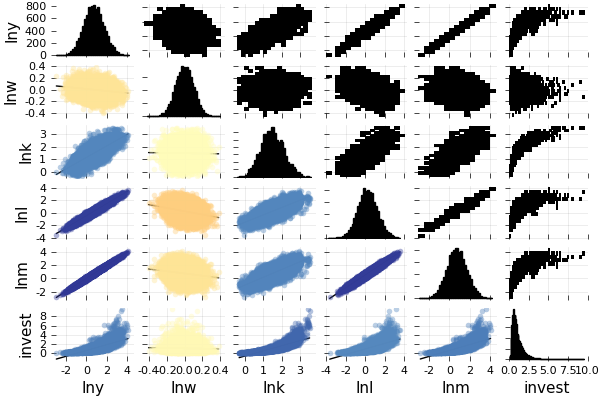

In [4]:
#----------------------------------------
using StatsPlots, Plots, PyPlot
pyplot()
vars = [:lny, :lnw, :lnk, :lnl, :lnm, :invest]
#Return a Boolean vector with true entries indicating rows without missing values (complete cases) in data frame df.
# If cols is provided, only missing values in the corresponding columns are considered.
inc = completecases(df[:,vars])
@df df[inc,vars] corrplot(cols(vars))

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = first_step_ACF(::DataFrame, ::Function; degree::Int64, deriv::Bool, bandwidth_multiplier::Float64) at In[8]:161
└ @ Main ./In[8]:161
┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = first_step_ACF(::DataFrame, ::Function; degree::Int64, deriv::Bool, bandwidth_multiplier::Float64) at In[8]:162
└ @ Main ./In[8]:162


  0.277818 seconds (132.77 k allocations: 234.707 MiB, 7.82% gc time)
  0.311227 seconds (245.33 k allocations: 241.609 MiB, 6.98% gc time)
 28.955547 seconds (400.79 M allocations: 49.865 GiB, 13.39% gc time)
 28.956420 seconds (400.79 M allocations: 49.865 GiB, 13.39% gc time)
Phi_difference = Plots.histogram(abs.(Phi .- Phi_locallinear), title = "1st stage local linear vs 4th degree polynomial") = Plot{Plots.PyPlotBackend() n=1}
Phi_difference = compare_first_step_ACF(df) = Plot{Plots.PyPlotBackend() n=1}


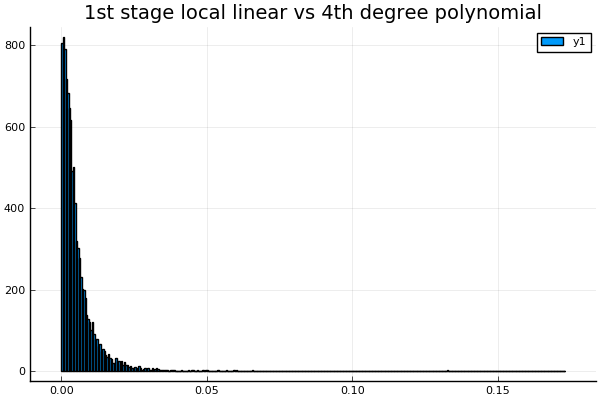

In [8]:
#################################
# Estimation section
#################################

#-------------------------------#
# Borrow functions based on https://github.com/UBCECON567/Dialysis/blob/7f4a79413bcb5d02f2f5a35b5406be01facc1e82/src/Dialysis.jl#LL496-L513
#-------------------------------#
"""
    panellag(x::Symbol, data::AbstractDataFrame, id::Symbol, t::Symbol,
              lags::Integer=1)
Create lags of variables in panel data.
Inputs:
  - `x` variable to create lag of
  - `data` DataFrame containing `x`, `id`, and `t`
  - `id` cross-section identifier
  - `t` time variable
  - `lags` number of lags. Can be negative, in which cause leads will
     be created
Output:
  - A vector containing lags of data[x]. Will be missing for `id` and
   `t` combinations where the lag is not contained in `data`.
"""
function panellag(x::Symbol, data::AbstractDataFrame, id::Symbol, t::Symbol,
                   lags::Integer=1)
  if (!issorted(data, (id, t)))
    @warn "data is not sorted, panellag() will be more efficient with a sorted DataFrame"
    p = sortperm(data, (id, t))
    df = data[p,:]
  else
    p = nothing
    df = data
  end
  idlag= ShiftedArrays.lag(df[!,id], lags)
  tlag = ShiftedArrays.lag(df[!,t], lags)
  xlag = ShiftedArrays.lag(df[!,x], lags)
  xlag = copy(xlag)
  xlag[ (typeof.(tlag).==Missing) .|
        (tlag .!= df[!,t].-lags) .|
        (idlag .!= df[!,id]) ] .= missing
  if (p == nothing)
    return(xlag)
  else
    xout = similar(xlag)
    xout[p] .= xlag
    return(xout)
  end
end
#panellag(:lnl, df, :firmid, :timeid, 1) #-1

"""
    locallinear(xpred::AbstractMatrix,
                xdata::AbstractMatrix,
                ydata::AbstractMatrix)
Computes local linear regression of ydata on xdata. Returns predicted
y at x=xpred. Uses Scott's rule of thumb for the bandwidth and a
Gaussian kernel. xdata should not include an intercept.
Inputs:
  - `xpred` x values to compute fitted y
  - `xdata` observed x
  - `ydata` observed y, must have `size(y)[1] == size(xdata)[1]`
  - `bandwidth_multiplier` multiply Scott's rule of thumb bandwidth by
     this number
Output:
  - Estimates of `f(xpred)`
"""
function locallinear(xpred::AbstractMatrix,
                     xdata::AbstractMatrix,
                     ydata::AbstractMatrix;
                     bandwidth_multiplier=1.0)

  (n, d) = size(xdata)
  ypred = Array{eltype(xpred), 2}(undef, size(xpred,1), size(ydata,2))
  # use Scott's rule of thumb
  rootH = n^(-1/(d+4))*vec(std(xdata;dims=1))*bandwidth_multiplier
  dist = MvNormal(rootH)
  function kernel(dx::AbstractVector) # Gaussian kernel
    pdf(dist, dx)
  end
  X = hcat(ones(n), xdata)
  w = Array{eltype(xpred), 1}(undef, n)
  for i in 1:size(xpred)[1]
    for j in 1:size(xdata)[1]
      w[j] = sqrt(kernel((xdata[j,:] - xpred[i,:])))
    end
    #ypred[i,:] = X[i,:]'* ((X'*Diagonal(w)*X) \
    #(X'*Diagonal(w)*ydata))
    ypred[i,:] = X[i,:]'* ((Diagonal(w)*X) \ (Diagonal(w)*ydata))
  end
  epsilon = ypred .-ydata
  return(ypred,epsilon)
end


"""
      polyreg(xpred::AbstractMatrix,
              xdata::AbstractMatrix,
              ydata::AbstractMatrix; degree=1)
Computes  polynomial regression of ydata on xdata. Returns predicted
y at x=xpred.
Inputs:
  - `xpred` x values to compute fitted y
  - `xdata` observed x
  - `ydata` observed y, must have `size(y)[1] == size(xdata)[1]`
  - `degree`
  - `deriv` whether to also return df(xpred). Only implemented when
    xdata is one dimentional
Output:
  - Estimates of `f(xpred)`
"""
function polyreg(xpred::AbstractMatrix,
                 xdata::AbstractMatrix,
                 ydata::AbstractMatrix;
                 degree=1, deriv=false)
  function makepolyx(xdata, degree, deriv=false)
    X = ones(size(xdata,1),1)
    dX = nothing
    for d in 1:degree
      Xnew = Array{eltype(xdata), 2}(undef, size(xdata,1), size(X,2)*size(xdata,2))
      k = 1
      for c in 1:size(xdata,2)
        for j in 1:size(X,2)
          Xnew[:, k] = X[:,j] .* xdata[:,c]
          k += 1
        end
      end
      X = hcat(X,Xnew)
    end
    if (deriv)
      if (size(xdata,2) > 1)
        error("polyreg only supports derivatives for one dimension x")
      end
      dX = zeros(eltype(X), size(X))
      for c in 2:size(X,2)
        dX[:,c] = (c-1)*X[:,c-1]
      end
    end
    return(X, dX)
  end
  X = makepolyx(xdata,degree)
  (Xp, dXp) = makepolyx(xpred,degree, deriv)
  coef = (X \ ydata)
  ypred = Xp * coef
  epsilon = ydata -ypred
  if (deriv)
    dy = dXp * coef
    return(ypred,coef, epsilon,dy)
  else
    return(ypred,coef,epsilon)
  end
end

#-----------------
#  First Stage (common in all approaches)
# acf_mata_original.do
# acf_mata_augmented.do
# acf_mata_sequential.do
#-----------------
using Plots: histogram
function first_step_ACF(df::DataFrame,npreg::Function;
	                    degree=4,deriv=false,bandwidth_multiplier=1.0)
	xdata = convert(Matrix, df[[:lnk,:lnl,:lnm]])
	ydata = convert(Matrix, df[[:lny]])
	if npreg == polyreg
		@time Phi,epsilon = polyreg(xdata,xdata,ydata,degree = degree, deriv=deriv)
		#0.283570 seconds (6.02 k allocations: 227.861 MiB, 15.94% gc time)
		return Phi, epsilon
	elseif npreg == locallinear
		@time Phi_locallinear,epsilon_locallinear = locallinear(xdata,xdata,ydata,bandwidth_multiplier=bandwidth_multiplier)
		#34.109292 seconds (400.66 M allocations: 49.858 GiB, 22.76% gc time)
		return Phi_locallinear,epsilon_locallinear #epsilon is null in this case
	end
end
function compare_first_step_ACF(df::DataFrame)
	@time Phi, epsilon = first_step_ACF(df,polyreg)
	#0.283570 seconds (6.02 k allocations: 227.861 MiB, 15.94% gc time)
	@time Phi_locallinear,epsilon_locallinear = first_step_ACF(df,locallinear)
	#34.109292 seconds (400.66 M allocations: 49.858 GiB, 22.76% gc time)
	@show Phi_difference=Plots.histogram(abs.(Phi.-Phi_locallinear),title="1st stage local linear vs 4th degree polynomial")
	return Phi_difference
end
@show Phi_difference = compare_first_step_ACF(df)


  0.255925 seconds (6.01 k allocations: 227.861 MiB, 15.49% gc time)
 30.921541 seconds (400.66 M allocations: 49.859 GiB, 13.62% gc time)
temp_plot = Plots.histogram(abs.(Phi .- Phi_locallinear), label = "diff degree4 - Phi_locallinear(band=0.5)") = Plot{Plots.PyPlotBackend() n=1}
 30.350447 seconds (400.66 M allocations: 49.859 GiB, 13.83% gc time)
temp_plot = Plots.histogram!(abs.(Phi .- Phi_locallinear), label = "diff degree4 - Phi_locallinear(band=1.0)") = Plot{Plots.PyPlotBackend() n=2}
 29.154288 seconds (400.66 M allocations: 49.859 GiB, 13.62% gc time)
temp_plot = Plots.histogram!(abs.(Phi .- Phi_locallinear), label = "diff degree4 - Phi_locallinear(band=1.5)") = Plot{Plots.PyPlotBackend() n=3}
  0.021903 seconds (1.65 k allocations: 56.696 MiB)
temp_plot = Plots.histogram!(abs.(Phi .- Phi_target), label = "diff degree4 - degree3", xlims = (0.0, 0.04), title = "1st stage difference across degrees") = Plot{Plots.PyPlotBackend() n=4}
  0.002400 seconds (494 allocations: 13.904 M

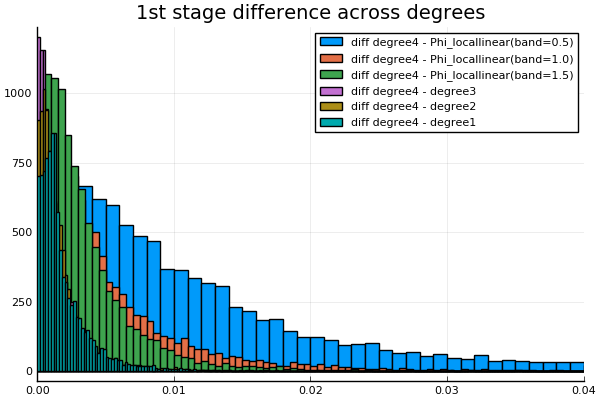

In [10]:
# 1st stage difference across degrees
function compare_first_step_ACF_degree_and_band(df)
	Phi, epsilon = first_step_ACF(df,polyreg,degree = 4)
	Phi_locallinear,~ = first_step_ACF(df,locallinear,bandwidth_multiplier=0.5)
	@show temp_plot=Plots.histogram(abs.(Phi.-Phi_locallinear),label="diff degree4 - Phi_locallinear(band=0.5)")
	Phi_locallinear,~ = first_step_ACF(df,locallinear,bandwidth_multiplier=1.0)
	@show temp_plot=Plots.histogram!(abs.(Phi.-Phi_locallinear),label="diff degree4 - Phi_locallinear(band=1.0)")
	Phi_locallinear,~ = first_step_ACF(df,locallinear,bandwidth_multiplier=1.5)
	@show temp_plot=Plots.histogram!(abs.(Phi.-Phi_locallinear),label="diff degree4 - Phi_locallinear(band=1.5)")
	Phi_target, ~ = first_step_ACF(df,polyreg,degree = 3)
	@show temp_plot=Plots.histogram!(abs.(Phi.-Phi_target),label="diff degree4 - degree3",xlims=((0.0,0.04)),title="1st stage difference across degrees")
	Phi_target, ~ = first_step_ACF(df,polyreg,degree = 2)
	@show temp_plot=Plots.histogram!(abs.(Phi.-Phi_target),label="diff degree4 - degree2")
	Phi_target, ~ = first_step_ACF(df,polyreg,degree = 1)
	@show temp_plot=Plots.histogram!(abs.(Phi.-Phi_target),label="diff degree4 - degree1")
	return temp_plot
end
@time temp_plot = compare_first_step_ACF_degree_and_band(df)
#113.400317 seconds (1.21 G allocations: 150.305 GiB, 25.38% gc time)



In [12]:
#  First Stage (common in all approaches)
Phi, epsilon = first_step_ACF(df,polyreg,degree = 1)
#-----------------
# Second Stage
# acf_mata_original.do
#-----------------
df[!,:phi] = Phi[:,1] # use Phi by polyreg
df[!,:phi_lag] = panellag(:phi, df, :firmid, :timeid, 1) # -1
df[!,:lnl_lag] = panellag(:lnl, df, :firmid, :timeid, 1) # -1
df[!,:lnk_lag] = panellag(:lnk, df, :firmid, :timeid, 1) # -1
df[!,:lnl_lag2] = panellag(:lnl_lag, df, :firmid, :timeid, 1) # -1
inc = completecases(df[:,1:end]) # deal with missing

#betas = [alphak, alphal]
function GMM_DLW(betas)
	global df,inc
	df_full = df[inc,1:end]
	#PHI=st_data(.,("phi"))
	PHI = df_full.phi
    #PHI_LAG=st_data(.,("phi_lag"))
	PHI_LAG =df_full.phi_lag
    #Z=st_data(.,("l_lag","k"))
	Z = [df_full.lnl_lag df_full.lnk]
    #X=st_data(.,("l","k"))
	X = [df_full.lnl df_full.lnk]
    #X_lag=st_data(.,("l_lag","k_lag"))
	X_lag = [df_full.lnl_lag df_full.lnk_lag]
    #Y=st_data(.,("y"))
	Y = df_full.lny
	#C=st_data(.,("const"))
	C = ones(size(df_full,1))
	#OMEGA=PHI-X*betas'
	OMEGA = PHI-X*betas
	#OMEGA_lag=PHI_LAG-X_lag*betas'
	OMEGA_lag=PHI_LAG-X_lag*betas
    #OMEGA_lag_pol= (OMEGA_lag,C)
	OMEGA_lag_pol= [OMEGA_lag C]
	#g_b = invsym(OMEGA_lag_pol'OMEGA_lag_pol)*OMEGA_lag_pol'OMEGA
	g_b = inv(OMEGA_lag_pol'*OMEGA_lag_pol)*(OMEGA_lag_pol'*OMEGA)
	#XI=OMEGA-OMEGA_lag_pol*g_b
	XI=OMEGA-OMEGA_lag_pol*g_b
	#crit=(Z'XI)'(Z'XI)
	crit=(Z'*XI)'*(Z'*XI)
	# Why KLS and ACF do not use weighting matrix?
	return crit
end

using Optim # github page : https://github.com/JuliaNLSolvers/Optim.jl
# docs : http://julianlsolvers.github.io/Optim.jl/stable/
@time @show res = Optim.optimize(GMM_DLW,
			   [par.alphal,par.alphak],#zeros(size(betas)), # initial value
			   BFGS(), # algorithm, see http://julianlsolvers.github.io/Optim.jl/stable/
			   autodiff=:forward)
@show betagmm = res.minimizer
#  0.055498 seconds (6.04 k allocations: 103.679 MiB, 42.45% gc time)
println("GMM_DLW julia gives $betagmm, $(DGP_specified)")
println("Stata gives .5933366487   .4198031481 ")


  0.000667 seconds (153 allocations: 3.201 MiB)
res = Optim.optimize(GMM_DLW, [par.alphal, par.alphak], BFGS(), autodiff = :forward) =  * Status: success

 * Candidate solution
    Minimizer: [5.95e-01, 4.08e-01]
    Minimum:   6.516750e-24

 * Found with
    Algorithm:     BFGS
    Initial Point: [6.00e-01, 4.00e-01]

 * Convergence measures
    |x - x'|               = 6.68e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.81e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.39e+06 ≰ 0.0e+00
    |g(x)|                 = 3.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    6
    f(x) calls:    23
    ∇f(x) calls:   23

  0.100058 seconds (94.60 k allocations: 69.191 MiB, 9.34% gc time)
betagmm = res.minimizer = [0.5950096387385297, 0.40769036547588805]
GMM_DLW julia gives [0.5950096387385297, 0.40769036547588805], DGP1
Stata gives .5933366487   .4198031481 


In [13]:
# other starting value
@time @show res = Optim.optimize(GMM_DLW,
			   [0.6,0.3],#zeros(size(betas)), # initial value
			   BFGS(), # algorithm, see http://julianlsolvers.github.io/Optim.jl/stable/
			   autodiff=:forward)
@show betagmm = res.minimizer
println("GMM_DLW julia gives $betagmm")
println("Stata gives .5933366487   .4198031481 ")

res = Optim.optimize(GMM_DLW, [0.6, 0.3], BFGS(), autodiff = :forward) =  * Status: success

 * Candidate solution
    Minimizer: [5.95e-01, 4.08e-01]
    Minimum:   7.247718e-25

 * Found with
    Algorithm:     BFGS
    Initial Point: [6.00e-01, 3.00e-01]

 * Convergence measures
    |x - x'|               = 4.27e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.18e-14 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.48e-21 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.42e+03 ≰ 0.0e+00
    |g(x)|                 = 8.04e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    23
    ∇f(x) calls:   23

  0.026646 seconds (3.66 k allocations: 64.447 MiB, 22.62% gc time)
betagmm = res.minimizer = [0.5950096387385266, 0.40769036547588977]
GMM_DLW julia gives [0.5950096387385266, 0.40769036547588977]
Stata gives .5933366487   .4198031481 


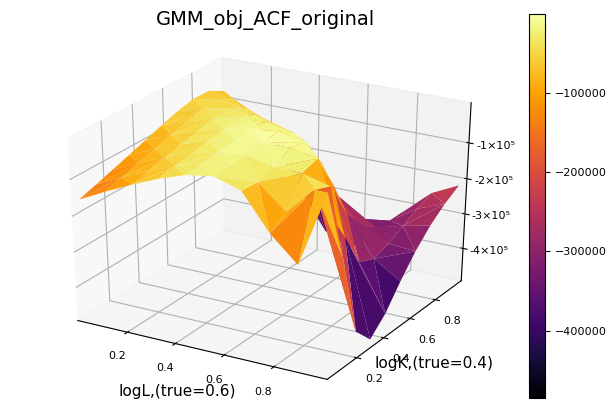

temp_plot = plot_mountain(GMM_DLW, "GMM_obj_ACF_original", grid = 10) = Plot{Plots.PyPlotBackend() n=1}


In [15]:
function plot_mountain(objfunc::Function,title;grid=10)
	temp = zeros(grid*grid,3)
	alphal_list = linspace(0.01,0.99,grid) # fix reasonable parameter space
	alphak_list = linspace(0.01,0.99,grid) # fix reasonable parameter space
	for i in 1:grid
		for j in 1:grid
			temp_alphal = alphal_list[j]
			temp_alphak = alphak_list[i]
			theta_start = convert(Array{Float64,1},[temp_alphal, temp_alphak])
			temp[i+(j-1)*grid,1] = temp_alphal
			temp[i+(j-1)*grid,2] = temp_alphak
			temp[i+(j-1)*grid,3] = objfunc([temp_alphal,temp_alphak]) #(alphak,alphal)
		end
	end
	#GMM_DLW(betagmm)
	# Generate mountain
	temp_plot = Plots.plot(xlabel = "logL,(true=$(par.alphal))",ylabel ="logK,(true=$(par.alphak))" )
	temp_plot = Plots.plot!(temp[:,1], temp[:,2] , -temp[:,3], st=:surface)
	temp_plot = Plots.plot!(title="$(title)")
	return temp_plot
end

function plot_contour(objfunc::Function,title;grid=10)
	alphal_list = linspace(0.01,0.99,grid) # fix reasonable parameter space
	alphak_list = linspace(0.01,0.99,grid) # fix reasonable parameter space
	# Generate contour
	f(x, y) = begin
	        -objfunc([x,y])
	end
	X = repeat(reshape(alphal_list, 1, :), length(alphak_list), 1)
	Y = repeat(alphak_list, 1, length(alphal_list))
	Z = map(f, X, Y)
	p1 = Plots.contour(alphal_list, alphak_list, f, fill = true)
	p2 = Plots.contour(alphal_list, alphak_list, Z)
	temp_plot = Plots.plot(p1, p2,xlabel = "logL,(true=$(par.alphal))",ylabel ="logK,(true=$(par.alphak))", title="$(title)"  )
	return temp_plot
end

@show temp_plot = plot_mountain(GMM_DLW,"GMM_obj_ACF_original",grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_original_mountain_$(DGP_specified)")


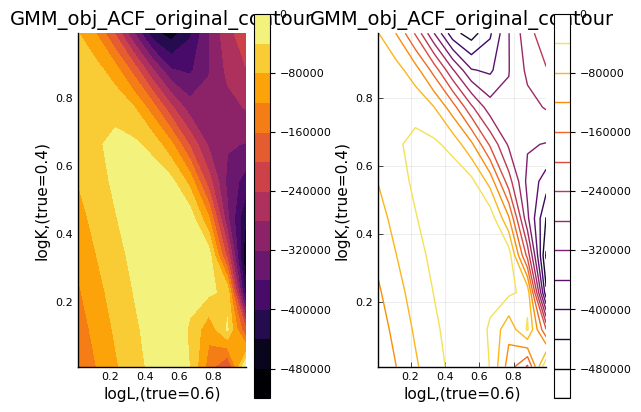

temp_plot = plot_contour(GMM_DLW, "GMM_obj_ACF_original_contour"; grid = 10) = Plot{Plots.PyPlotBackend() n=2}


In [16]:
@show temp_plot = plot_contour(GMM_DLW,"GMM_obj_ACF_original_contour";grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_original_contour_$(DGP_specified)")


res = Optim.optimize(GMM_DLW_augment, [par.alphal, par.alphak], BFGS(), autodiff = :forward) =  * Status: success

 * Candidate solution
    Minimizer: [5.95e-01, 3.94e-01]
    Minimum:   4.439777e+00

 * Found with
    Algorithm:     BFGS
    Initial Point: [6.00e-01, 4.00e-01]

 * Convergence measures
    |x - x'|               = 4.26e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.16e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.58e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.05e-13 ≰ 0.0e+00
    |g(x)|                 = 2.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    6
    f(x) calls:    47
    ∇f(x) calls:   47

  3.086804 seconds (8.25 M allocations: 614.168 MiB, 3.57% gc time)
betagmm_augment = res.minimizer = [0.5952473093960636, 0.39403238939858426]
GMM_DLW_augment julia gives [0.5952473093960636, 0.39403238939858426]
Stata gives .5933366487   .4198031481 
temp_plot = plot_mountain(GMM_DLW_augment, "GMM_obj_ACF_augment", grid = 10) = 

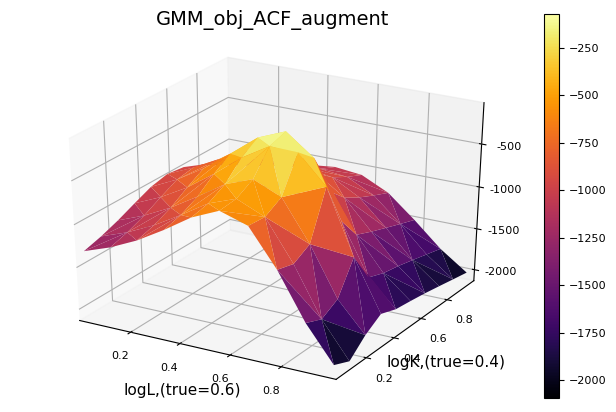

Plot{Plots.PyPlotBackend() n=1}


In [17]:
using Statistics
function GMM_DLW_augment(betas)
	#acf_mata_augmented.do
	global df,inc
	df_full = df[inc,1:end]
	PHI = df_full.phi
	PHI_LAG =df_full.phi_lag
    C = ones(size(df_full,1))
	#Z=st_data(.,("const","l_lag","k","k_lag","l_lag2"))
	# Note additional instruments
	Z = [C df_full.lnl_lag df_full.lnk df_full.lnk_lag df_full.lnl_lag2]
	#X=st_data(.,("l","k"))
	X = [df_full.lnl df_full.lnk]
	X_lag = [df_full.lnl_lag df_full.lnk_lag]
	Y = df_full.lny
	#C=st_data(.,("const"))
	C = ones(size(df_full,1))
	OMEGA = PHI-X*betas
	OMEGA_lag=PHI_LAG-X_lag*betas
    #OMEGA_lag_pol= (OMEGA_lag,C)
	#OMEGA_lag_pol= (OMEGA_lag)
	OMEGA_lag_pol= OMEGA_lag # drop C
	g_b = inv(OMEGA_lag_pol'*OMEGA_lag_pol)*(OMEGA_lag_pol'*OMEGA)
	XI=OMEGA-OMEGA_lag_pol*g_b
	#--------------#
	# the following moments are different from
	# original ACF
	#--------------#
	#=
	mom1 = XI:*Z[.,1]
	mom2 = XI:*Z[.,2]
	mom3 = XI:*Z[.,3]
	mom4 = XI:*Z[.,4]
	mom5 = XI:*Z[.,5]
	mom = (mom1,mom2,mom3,mom4,mom5)
	=#
	mom = XI.*Z
	#vce = variance(mom)
	vce = Statistics.cov(mom) # variance-covariance matrix
	#W = invsym(vce) /rows(Z)
	W = inv(vce)./size(Z,1)
	#crit= (Z'XI)'*W*(Z'XI)
	crit=(Z'*XI)'*W*(Z'*XI)
end
@time @show res = Optim.optimize(GMM_DLW_augment,
			   [par.alphal,par.alphak],#zeros(size(betas)), # initial value
			   BFGS(), # algorithm, see http://julianlsolvers.github.io/Optim.jl/stable/
			   autodiff=:forward)
@show betagmm_augment = res.minimizer
#1.448595 seconds
println("GMM_DLW_augment julia gives $betagmm_augment")
println("Stata gives .5933366487   .4198031481 ")

#[0.5982173422462218, 0.4048278014727469]

#GMM_DLW(betagmm)
# Generate mountain
@show temp_plot = plot_mountain(GMM_DLW_augment,"GMM_obj_ACF_augment",grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_augment_mountain_$(DGP_specified)")

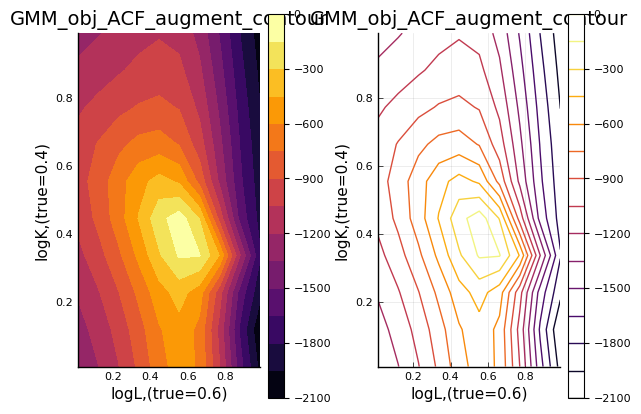

temp_plot = plot_contour(GMM_DLW_augment, "GMM_obj_ACF_augment_contour"; grid = 10) = Plot{Plots.PyPlotBackend() n=2}


In [18]:
# Generate contour
@show temp_plot = plot_contour(GMM_DLW_augment,"GMM_obj_ACF_augment_contour";grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_augment_contour_$(DGP_specified)")



res = Optim.optimize(GMM_DLW_sequential, [par.alphal, par.alphak], BFGS(), autodiff = :forward) =  * Status: success

 * Candidate solution
    Minimizer: [5.44e-01, 4.60e-01]
    Minimum:   2.824633e+01

 * Found with
    Algorithm:     BFGS
    Initial Point: [6.00e-01, 4.00e-01]

 * Convergence measures
    |x - x'|               = 2.41e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.43e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.85e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.72e-13 ≰ 0.0e+00
    |g(x)|                 = 1.29e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    78
    ∇f(x) calls:   78

  2.593553 seconds (7.38 M allocations: 621.391 MiB, 3.57% gc time)
GMM_DLW_sequential julia gives [0.5437062760609574, 0.46010232940773704]
Stata gives .5933366487   .4198031481 


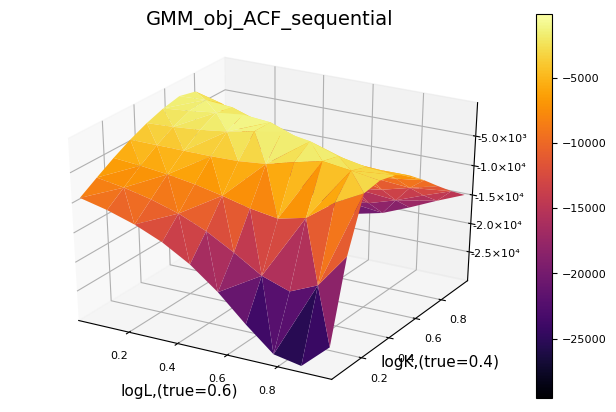

temp_plot = plot_mountain(GMM_DLW_sequential, "GMM_obj_ACF_sequential", grid = 10) = Plot{Plots.PyPlotBackend() n=1}


In [19]:
#-------------------#
# acf_mata_sequential.do
#-------------------#
#forvalues s = 1(1)`starting'{
#gen initiall = 0.1*(`s'-1)
#gen initialk = 0.1*(11-`s')
initiall = 0.5
initialk = 0.5
function GMM_DLW_sequential(betas)
	#acf_mata_augmented.do
	global df,inc
	df_full = df[inc,1:end]
	PHI = df_full.phi
	PHI_LAG =df_full.phi_lag
    C = ones(size(df_full,1))
	#Z=st_data(.,("const","l_lag","k"))
	# Note additional instruments
	Z = [C df_full.lnl_lag df_full.lnk]
	#X=st_data(.,("l","k"))
	X = [df_full.lnl df_full.lnk]
	X_lag = [df_full.lnl_lag df_full.lnk_lag]
	Y = df_full.lny
	#C=st_data(.,("const"))
	C = ones(size(df_full,1))
	#betarhs = st_data(1,("initiall","initialk"))
	global initiall, initialk
	betarhs = [initiall,initialk]
	OMEGA = PHI-X*betas
	OMEGA_lag=PHI_LAG-X_lag*betarhs
    #OMEGA_lag_pol= (OMEGA_lag,C)
	#OMEGA_lag_pol= (OMEGA_lag)
	OMEGA_lag_pol= OMEGA_lag # drop C
	g_b = inv(OMEGA_lag_pol'*OMEGA_lag_pol)*(OMEGA_lag_pol'*OMEGA)
	XI=OMEGA-OMEGA_lag_pol*g_b
	#--------------#
	# the following moments are different from
	# original ACF
	#--------------#
	#=
	mom1 = XI:*Z[.,1]
	mom2 = XI:*Z[.,2]
	mom3 = XI:*Z[.,3]
	mom = (mom1,mom2,mom3)
	=#
	mom = XI.*Z
	#vce = variance(mom)
	vce = Statistics.cov(mom) # variance-covariance matrix
	#W = invsym(vce) /rows(Z)
	W = inv(vce)./size(Z,1)
	#crit= (Z'XI)'*W*(Z'XI)
	crit=(Z'*XI)'*W*(Z'*XI)
end

@time @show res = Optim.optimize(GMM_DLW_sequential,
			   [par.alphal,par.alphak],#zeros(size(betas)), # initial value
			   BFGS(), # algorithm, see http://julianlsolvers.github.io/Optim.jl/stable/
			   autodiff=:forward)
betagmm_sequential = res.minimizer
println("GMM_DLW_sequential julia gives $betagmm_sequential")
println("Stata gives .5933366487   .4198031481 ")

#-------------------------------------------
# Illustrate GMM objective function mountain
# acf_mata_sequential.do
#-------------------------------------------
@show temp_plot = plot_mountain(GMM_DLW_sequential,"GMM_obj_ACF_sequential",grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_sequential_mountain_$(DGP_specified)")

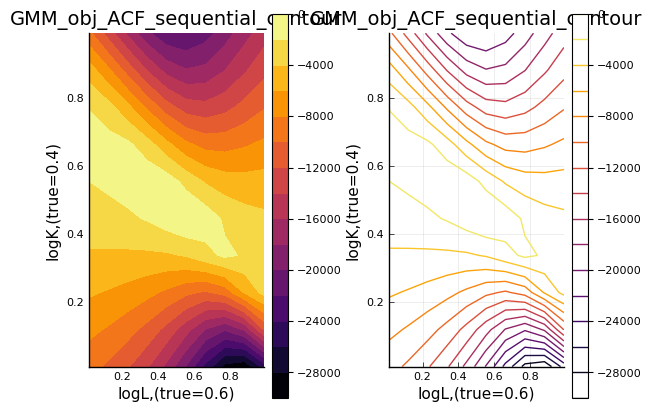

temp_plot = plot_contour(GMM_DLW_sequential, "GMM_obj_ACF_sequential_contour"; grid = 10) = Plot{Plots.PyPlotBackend() n=2}


In [20]:

# Generate contour
@show temp_plot = plot_contour(GMM_DLW_sequential,"GMM_obj_ACF_sequential_contour";grid=10)
Plots.savefig(temp_plot,"GMM_obj_ACF_sequential_contour_$(DGP_specified)")
#------------------------

Try to implement experimentations for timeb
based on il Kim, K., Luo, Y., & Su, Y. (2019). Production Function Estimation Robust to Flexible Timing of Labor Input.
temp_timeb = 0.0
lnpdata = allzeros. Problematic for nonzeros??
  1.555653 seconds (7.32 M allocations: 589.520 MiB, 6.83% gc time)
  0.229235 seconds (6.01 k allocations: 227.861 MiB, 14.65% gc time)
temp_plot = plot_mountain(GMM_DLW_augment, "GMM_obj_ACF_augment(timeb_$(temp_timeb))", grid = 10) = Plot{Plots.PyPlotBackend() n=1}
temp_plot = plot_contour(GMM_DLW_augment, "GMM_obj_ACF_augment_contour(timeb_$(temp_timeb))"; grid = 10) = Plot{Plots.PyPlotBackend() n=2}
temp_plot = plot_mountain(GMM_DLW_sequential, "GMM_obj_ACF_sequential(timeb_$(temp_timeb))", grid = 10) = Plot{Plots.PyPlotBackend() n=1}
temp_plot = plot_contour(GMM_DLW_sequential, "GMM_obj_ACF_sequential_contour(timeb_$(temp_timeb))"; grid = 10) = Plot{Plots.PyPlotBackend() n=2}
temp_timeb = 0.25
lnpdata = allzeros. Problematic for nonzeros??
  1.549320 secon

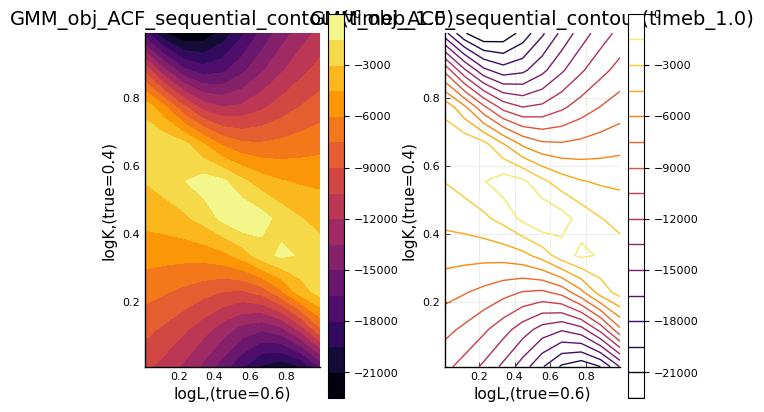

21.116800 seconds (40.85 M allocations: 13.872 GiB, 5.61% gc time)


In [21]:
println("Try to implement experimentations for timeb
based on il Kim, K., Luo, Y., & Su, Y. (2019). Production Function Estimation Robust to Flexible Timing of Labor Input.")

function compare_laborinput_timing(;temp_timeb=0.5)
	par = acf_mod(timeb=temp_timeb)
	# generate data
	@time lnwdata,lnkdata,lnldata,lnydata,lnmdata, investmat = gen_data_all(par)
	#6.489150 seconds (10.16 M allocations: 654.953 MiB, 2.05% gc time)
	DGP1 = [lnkdata[:,(par.starttime+1):(par.starttime+par.t)] lnldata[:,(par.starttime+1):(par.starttime+par.t)] lnmdata[:,(par.starttime+1):(par.starttime+par.t)] lnydata[:,(par.starttime+1):(par.starttime+par.t)]];
	firmid=[1:1:par.n;]
	timeid=[1:1:par.t;]
	df = DataFrame(gridmake(firmid, timeid))
	df = rename(df, :x1 => :firmid)
	df = rename(df, :x2 => :timeid)
	df[!,:lny] = vec(lnydata[:,(par.starttime+1):(par.starttime+par.t)])
	df[!,:lnw] = vec(lnwdata[:,(par.starttime+1):(par.starttime+par.t)])
	df[!,:lnk] = vec(lnkdata[:,(par.starttime+1):(par.starttime+par.t)])
	df[!,:lnl] = vec(lnldata[:,(par.starttime+1):(par.starttime+par.t)])
	df[!,:lnm] = vec(lnmdata[:,(par.starttime+1):(par.starttime+par.t)])
	df[!,:invest] = vec(investmat[:,(par.starttime+1):(par.starttime+par.t)])
	df = sort(df,:firmid)
	#  First Stage (common in all approaches)
	Phi, epsilon = first_step_ACF(df,polyreg)
	# Second Stage
	df[!,:phi] = Phi[:,1] # use Phi by polyreg
	df[!,:phi_lag] = panellag(:phi, df, :firmid, :timeid, 1) # -1
	df[!,:lnl_lag] = panellag(:lnl, df, :firmid, :timeid, 1) # -1
	df[!,:lnk_lag] = panellag(:lnk, df, :firmid, :timeid, 1) # -1
	df[!,:lnl_lag2] = panellag(:lnl_lag, df, :firmid, :timeid, 1) # -1
	inc = completecases(df[:,1:end]) # deal with missing
	return df
end
#compare_laborinput_timing(temp_timeb=0.5)
timeb_list=[0.0:0.25:1.0;]
@time for i = 1:length(timeb_list)
	temp_timeb = timeb_list[i]
	@show temp_timeb
	global df = compare_laborinput_timing(temp_timeb=temp_timeb)
	# Generate mountain
	temp_plot = plot_mountain(GMM_DLW,"GMM_obj_ACF_original(timeb_$(temp_timeb))",grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_original_mountain(timeb_$(temp_timeb)).png")
	# Generate contour
	temp_plot = plot_contour(GMM_DLW,"GMM_obj_ACF_original_contour(timeb_$(temp_timeb))";grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_original_contour(timeb_$(temp_timeb))_$(DGP_specified).png")

	# Generate mountain
	@show temp_plot = plot_mountain(GMM_DLW_augment,"GMM_obj_ACF_augment(timeb_$(temp_timeb))",grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_augment_mountain(timeb_$(temp_timeb))_$(DGP_specified).png")
	# Generate contour
	@show temp_plot = plot_contour(GMM_DLW_augment,"GMM_obj_ACF_augment_contour(timeb_$(temp_timeb))";grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_augment_contour(timeb_$(temp_timeb))_$(DGP_specified).png")

	# generate mountain
	@show temp_plot = plot_mountain(GMM_DLW_sequential,"GMM_obj_ACF_sequential(timeb_$(temp_timeb))",grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_sequential_mountain(timeb_$(temp_timeb))_$(DGP_specified).png")
	# Generate contour
	@show temp_plot = plot_contour(GMM_DLW_sequential,"GMM_obj_ACF_sequential_contour(timeb_$(temp_timeb))";grid=10)
	Plots.savefig(temp_plot,"GMM_obj_ACF_sequential_contour(timeb_$(temp_timeb))_$(DGP_specified).png")
end
#17.725704 seconds (30.55 M allocations: 10.974 GiB, 11.91% gc time)

#--------------#
# End of the codes
#--------------#